<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 
<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="max-width: 150px; display: inline"  alt="Wikistat"/></a>
<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" width=400,  style="float:right;  display: inline" alt="IMT"/> </a>
    
</center>

# High Dimensional & Deep Learning : Autoencoders

##  What is an Autoencoder ?

<P style="text-align:center"><img src="https://blog.keras.io/img/ae/autoencoder_schema.jpg" style="float:center; display: inline" alt="schema"/></P>
<i>Autoencoder architecture</i>

## Objective 

During this TP  we will build different autoencoders with Keras and Tensorflow. Here are the main objectives :

* Build a autoencoder based on simple perceptron layer.
* Add regularization on layer and understand its effects.
* Build a convolutional autoencoder.
* Use a convolutional autoencoder to solve denoising problem.
* Manipulate the library in order to get and observe the result at different point of the dataflow.


The dataset used all along with TP is the MNIST dataset.

**EDIT**: 30/08/2019 Use Tensorflow V1 for this TP as Tensorflow V2 produce very unstable results.

## Library

In [17]:
from tensorflow.keras.datasets import mnist
import tensorflow.keras.preprocessing.image as kpi
import tensorflow.keras.models as km
import tensorflow.keras.layers as kl
import tensorflow.keras.regularizers as kr
import tensorflow.keras.optimizers as ko
import numpy as np

import matplotlib.pyplot as plt
import tensorflow
tensorflow.__version__

'2.0.0-beta1'

## Dataset 
As we won't apply any supervised algorithm in this TP, we do not need to load the `Y` variable.

In [6]:
(x_train, _), (x_test, _) = mnist.load_data()

As seen in the previous TP, it is better to normalize the dataset before to apply algorithm on it.

(60000, 28, 28)
(10000, 28, 28)


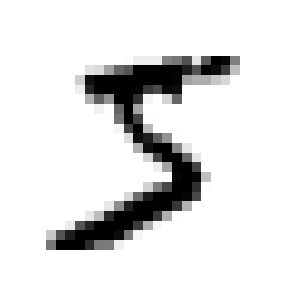

In [7]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
print(x_train.shape)
print(x_test.shape)

fig  = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
x = kpi.img_to_array(x_train[0])
ax.imshow(x[:,:,0], interpolation='nearest', cmap="binary")
ax.grid(False)
plt.axis('off')
plt.show()

## Building a simple autoencoder

We will first build a very simple architecture where :

* the **encoder layer** : is a `Dense` layer composed of 32 neurons (the latent variable) with a `Relu` activation function :
$$relu(x) = max(0,x)$$
* the **decoded layer** : is a `Dense` layer composed of  784 neurons (the input dimension) with a `Sigmoid`activation function.
$$sigmoid(x) = \frac{1}{1+\text{e}^x}$$




We first reshape the data from to be 1D.

In [8]:
x_train_flatten = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_flatten = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_train_flatten.shape, x_test_flatten.shape

((60000, 784), (10000, 784))

### Write the model

**Exercice** : write the simple model described above in keras.

In [9]:
n_latent = 32
n_input = 784

In [25]:
autoencoder = km.Sequential(name="simple_autoencoder")
autoencoder.add(kl.Dense(n_latent, activation='relu', input_shape=(n_input,)))
autoencoder.add(kl.Dense(n_input, activation='sigmoid'))

In [26]:
autoencoder.summary()

Model: "simple_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_5 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [27]:
# %load solutions/simple_autoencoder.py

We then learn the model. Note that the target variable are the original image.

In [28]:
autoencoder.compile(optimizer=ko.Adadelta(lr=1), loss='binary_crossentropy')
autoencoder.fit(x_train_flatten, x_train_flatten, epochs=50, batch_size=256, validation_data=(x_test_flatten, x_test_flatten))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 19us/sample - loss: 0.3598 - val_loss: 0.2715
Epoch 2/50
60000/60000 [==============================] - 1s 17us/sample - loss: 0.2643 - val_loss: 0.2534
Epoch 3/50
60000/60000 [==============================] - 1s 17us/sample - loss: 0.2427 - val_loss: 0.2295
Epoch 4/50
60000/60000 [==============================] - 1s 17us/sample - loss: 0.2212 - val_loss: 0.2111
Epoch 5/50
60000/60000 [==============================] - 1s 18us/sample - loss: 0.2060 - val_loss: 0.1986
Epoch 6/50
60000/60000 [==============================] - 1s 18us/sample - loss: 0.1955 - val_loss: 0.1900
Epoch 7/50
60000/60000 [==============================] - 1s 17us/sample - loss: 0.1877 - val_loss: 0.1830
Epoch 8/50
60000/60000 [==============================] - 1s 17us/sample - loss: 0.1813 - val_loss: 0.1769
Epoch 9/50
60000/60000 [==============================] - 1s 17us/sample - loss: 0.1756 - val_

**Question** : We use the binary cross entropy here as in the original paper [1](https://arxiv.org/pdf/1312.6114.pdf)? Does it look like a intuitive choice? Why?
How is the loss evoluting during training?

**R** Ce n'est pas intuitif car la binary cross entropy est normalement faite pour des labels de 0 ou 1.  
La loss function diminue durant l'entrainement, mais très légèrement.

### Check outputs

We will no check how the model performs. We produce first the encoded-decoded images.

In [29]:
decoded_test_imgs = autoencoder.predict(x_test_flatten)

The following function display both the input and the output of the autoencoder model.

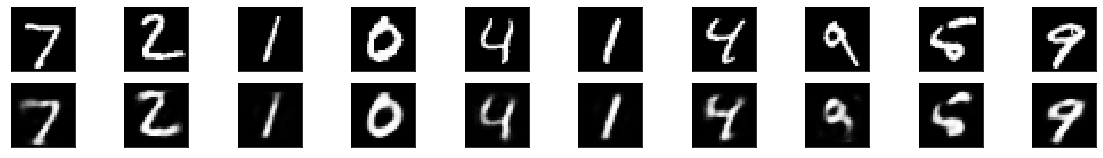

In [30]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_test_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**Question** : What can you say about this results?

**R** : C'est bien mais pas fantastique non plus, un peu flou par endroits.

### Check latent variable

The keras model that we have written above does not allow us to retrieve the latent variable. 
In order to do so, we have to re-write the model in order to get this variable late.

We first write the encoder part.

In [31]:
encoder = km.Sequential(name="EncoderModel")
encoder.add(kl.Dense(n_latent, activation='relu', input_shape=(n_input,),name="encoder_layer"))

We then write the decoder as  another independent model

In [32]:
decoder = km.Sequential(name="DecoderModel")
decoder.add(kl.Dense(n_input, activation='sigmoid', input_shape =(n_latent,), name = "decoded_layer" ))

We finally writhe the autoencoder model by adding the two previous model

In [33]:
autoencoder = km.Sequential(name="EncoderDecoder")
autoencoder.add(encoder)
autoencoder.add(decoder)

The model is well composed of the association of the two previous model.

In [34]:
autoencoder.summary()

Model: "EncoderDecoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EncoderModel (Sequential)    (None, 32)                25120     
_________________________________________________________________
DecoderModel (Sequential)    (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


You can acces the two sub model with the following syntax

In [35]:
autoencoder.get_layer("EncoderModel").summary()

Model: "EncoderModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_layer (Dense)        (None, 32)                25120     
Total params: 25,120
Trainable params: 25,120
Non-trainable params: 0
_________________________________________________________________


The model can then be learned the same way.

In [37]:
autoencoder.compile(optimizer=ko.Adadelta(lr=1), loss='binary_crossentropy')
autoencoder.fit(x_train_flatten, x_train_flatten, epochs=50, batch_size=256, validation_data=(x_test_flatten, x_test_flatten))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 19us/sample - loss: 0.3517 - val_loss: 0.2718
Epoch 2/50
60000/60000 [==============================] - 1s 16us/sample - loss: 0.2655 - val_loss: 0.2560
Epoch 3/50
60000/60000 [==============================] - 1s 16us/sample - loss: 0.2484 - val_loss: 0.2383
Epoch 4/50
60000/60000 [==============================] - 1s 16us/sample - loss: 0.2306 - val_loss: 0.2197
Epoch 5/50
60000/60000 [==============================] - 1s 16us/sample - loss: 0.2133 - val_loss: 0.2039
Epoch 6/50
60000/60000 [==============================] - 1s 17us/sample - loss: 0.1997 - val_loss: 0.1928
Epoch 7/50
60000/60000 [==============================] - 1s 16us/sample - loss: 0.1902 - val_loss: 0.1849
Epoch 8/50
60000/60000 [==============================] - 1s 17us/sample - loss: 0.1830 - val_loss: 0.1783
Epoch 9/50
60000/60000 [==============================] - 1s 17us/sample - loss: 0.1769 - val_

**Question** What can you say about the loss value of the model.

**R** C'est la même chose que tout à l'heure ce qui est normal puisqu'on a créé un autoencoder avec la même structure que précédemment. On l'a juste séparé en deux modèles : un encoder et un decoder.

We can now access and produce easily the latent variable

In [38]:
encoded_imgs = encoder.predict(x_test_flatten)
encoded_imgs.shape

(10000, 32)

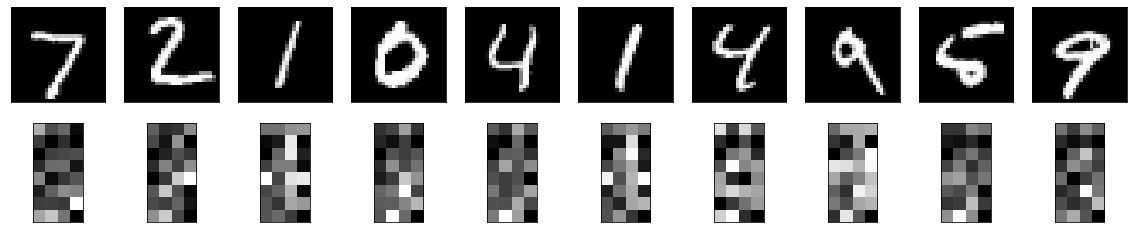

In [39]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display encoded imgs
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape(8, 4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

You can produce the decoded images by :
* Using the decoded part on the encoded images.
* Using the all architecture on the original image.

**Exercise** : Check that both methods produce the same results

In [40]:
decoded_imgs = decoder.predict(encoded_imgs)
decoded_imgs.shape

(10000, 784)

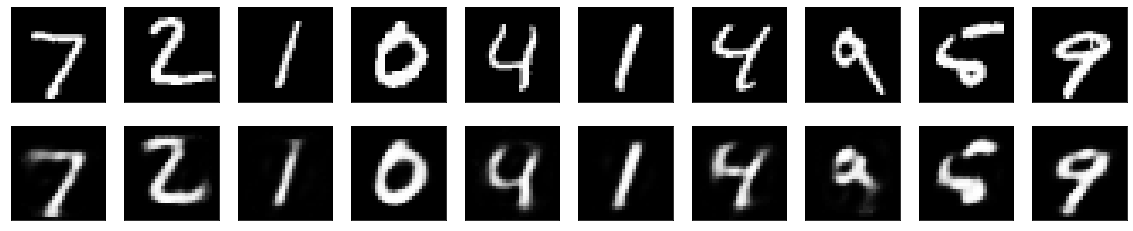

In [41]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display encoded imgs
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [43]:
np.allclose(decoded_imgs, autoencoder.predict(x_test_flatten))

True

In [ ]:
# %load solutions/decoded_images_both_method.py

## Sparse autoencoder

In the previous example the autoencoder is only constrained by the size of the hidden layer. 

In the following figure you can see the distribution of the number of latent variable set to zero for the 10.000 test images.

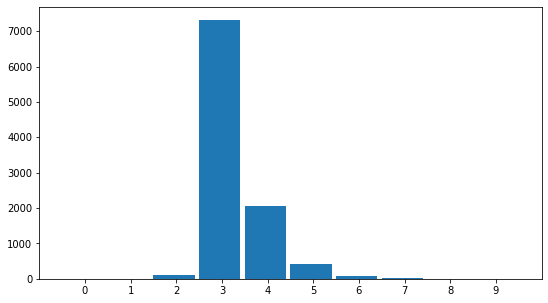

In [44]:
fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(1,1,1)
ax.hist(np.sum(encoded_imgs==0,axis=1), width=0.9, bins=np.arange(-0.5,10.5,1))
ax.set_xticks(np.arange(10))
plt.show()

Another way to get a sparser encoded representation of the images is to add a *sparsity contraint* on the activity function of the hidden layer. 

Regularizers enable to avoid overfitting by adding some constraint on the weight we want to control. 

Cost function = Loss (say, binary cross entropy) + Regularization term 

Cost function = Loss + $\lambda$ $\sum w$, where in our case $\lambda = 10e-5$ and $w$ are the weight of the encoder model.

In [45]:
l = 10e-5

sparse_encoder = km.Sequential(name="SparseEncoderModel")
sparse_encoder.add(kl.Dense(n_latent, activation='relu', input_shape=(n_input,), activity_regularizer=kr.l1(l) ,name="encoder_layer"))

sparse_decoder = km.Sequential(name="SparseDecoderModel")
sparse_decoder.add(kl.Dense(n_input, activation='sigmoid', input_shape =(n_latent,), name = "decoded_layer" ))

sparse_autoencoder = km.Sequential(name="SparseEncoderDecoder")
sparse_autoencoder.add(sparse_encoder)
sparse_autoencoder.add(sparse_decoder)


you can now train the model as previously

In [47]:
sparse_autoencoder.compile(optimizer=ko.Adadelta(lr=1), loss='binary_crossentropy')
sparse_autoencoder.fit(x_train_flatten, x_train_flatten, epochs=50, batch_size=256,validation_data=(x_test_flatten, x_test_flatten))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 21us/sample - loss: 0.3591 - val_loss: 0.2776
Epoch 2/50
60000/60000 [==============================] - 1s 17us/sample - loss: 0.2701 - val_loss: 0.2597
Epoch 3/50
60000/60000 [==============================] - 1s 17us/sample - loss: 0.2503 - val_loss: 0.2391
Epoch 4/50
60000/60000 [==============================] - 1s 17us/sample - loss: 0.2318 - val_loss: 0.2226
Epoch 5/50
60000/60000 [==============================] - 1s 17us/sample - loss: 0.2178 - val_loss: 0.2106
Epoch 6/50
60000/60000 [==============================] - 1s 18us/sample - loss: 0.2073 - val_loss: 0.2014
Epoch 7/50
60000/60000 [==============================] - 1s 19us/sample - loss: 0.1989 - val_loss: 0.1938
Epoch 8/50
60000/60000 [==============================] - 1s 18us/sample - loss: 0.1923 - val_loss: 0.1880
Epoch 9/50
60000/60000 [==============================] - 1s 18us/sample - loss: 0.1869 - val_

**Question** : What can you say on the loss function compare to the previous model?

**R** La loss function est un peu plus haute que précédemment, mais c'est normal puisqu'on a rajouté des contraintes de sparsité.

**Exercise**  : Check that the encoded images obtained with the sparse autoencoder are indeed sparser than the ones obtain by the first autoencoder 

In [48]:
sparse_encoded_imgs = sparse_encoder.predict(x_test_flatten)

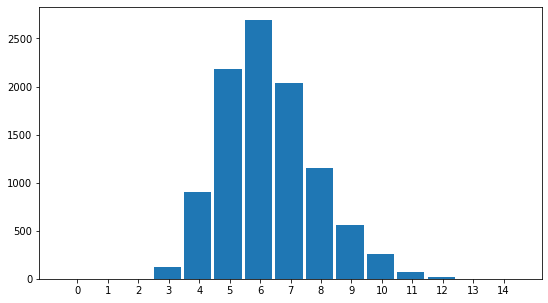

In [58]:
fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(1,1,1)
ax.hist(np.sum(sparse_encoded_imgs<=1e-8,axis=1), width=0.9, bins=np.arange(-0.5,15.5,1))
ax.set_xticks(np.arange(15))
plt.show()

In [ ]:
# %load solutions/compare_sparsity_encoded_imgs.py

**Exercise** : Compare the decoded images obtain by the first and the sparse model

In [59]:
sparse_decoded_imgs = sparse_decoder.predict(sparse_encoded_imgs)

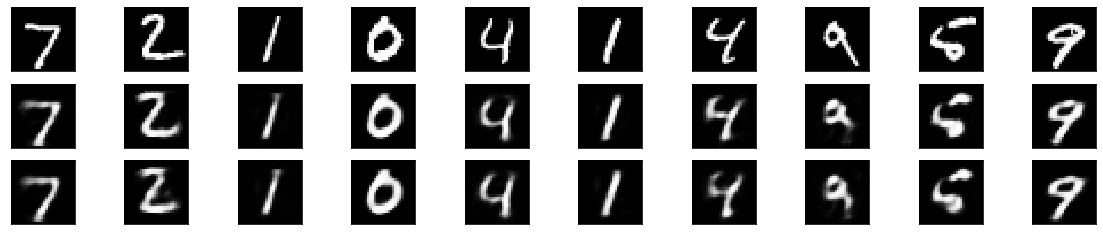

In [64]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display encoded imgs
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded sparse imgs
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(sparse_decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# %load solutions/compare_sparsity_decoded_imgs.py

On observe de très légères différences sur certains des chiffres (le 4 par exemple est un peu plus flou avec la contrainte de sparsité), mais les résultats sont quand mêmes encourageants.

## Convolutional Autoencoder

In the previous part, we have seen very simple autoencoder where both encoder and decoder part are composed of single layer. They both can be composed of more layers (deep autoencoder) and with differents types of layer.

As seen in the previous TP, convolutional layers are the best layer to use when dealing with images. 

**Exercise** : Implement a convolutional Autoencoder with the folowwing architecture: 

conv_decoder = km.Sequential(name="ConvDecoderModel")
conv_decoder.add(kl.Conv2D(8, (3, 3), activation='relu', input_shape = conv_encoder.get_output_shape_at(-1)[-3:], padding='same'))
conv_decoder.add(kl.UpSampling2D((2, 2)))
conv_decoder.add(kl.Conv2D(8, (3, 3), activation='relu', padding='same'))
conv_decoder.add(kl.UpSampling2D((2, 2)))
conv_decoder.add(kl.Conv2D(16, (3, 3), activation='relu'))
conv_decoder.add(kl.UpSampling2D((2, 2)))
conv_decoder.add(kl.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

`Encoder`
* A 2d convolutional layer, 16 filters of size 3x3
* A 2Dmaxpooling layer with filters of size 2x2
* A 2d convolutial layer, 8 filters of size 3x3
* A 2Dmaxpooling layer with filters of size 2x2
* A 2d convolutial layer, 8 filters of size 3x3
* A 2Dmaxpooling layer with filters of size 2x2

`Decoder`
* A 2d convolutional layer, 8 filters of size 3x3
* A 2Dupsampling layer with filters of size 2x2
* A 2d convolutional layer, 8 filters of size 3x3
* A 2Dupsampling layer with filters of size 2x2
* A 2d convolutional layer, 16 filters of size 3x3
* A 2Dupsampling layer with filters of size 2x2
* A 2d convolutional layer, 1 filters of size 3x3, with SIGMOID activation


*All padding are `SAME` padding and all convolutional activation function but last are `RELU`*



In [89]:
conv_encoder = km.Sequential(name="conv_encoder")
conv_encoder.add(kl.Conv2D(16, (3, 3), input_shape=(28, 28, 1, ), activation='relu', padding='same'))
conv_encoder.add(kl.MaxPooling2D((2, 2), padding='same'))
conv_encoder.add(kl.Conv2D(8, (3, 3), activation='relu', padding='same'))
conv_encoder.add(kl.MaxPooling2D((2, 2), padding='same'))
conv_encoder.add(kl.Conv2D(8, (3, 3), activation='relu', padding='same'))
conv_encoder.add(kl.MaxPooling2D((2, 2), padding='same'))

conv_encoder.summary()

Model: "conv_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 4, 8)           0         
Total params: 1,904
Trainable params: 1,904
Non-trainable params: 0
____________________________________________________

In [90]:
conv_decoder = km.Sequential(name="conv_decoder")
conv_decoder.add(kl.Conv2D(8, (3, 3), input_shape=(4, 4, 8, ), activation='relu', padding='same'))
conv_decoder.add(kl.UpSampling2D((2, 2)))
conv_decoder.add(kl.Conv2D(8, (3, 3), activation='relu', padding='same'))
conv_decoder.add(kl.UpSampling2D((2, 2)))
conv_decoder.add(kl.Conv2D(16, (3, 3), activation='relu', padding='valid'))
conv_decoder.add(kl.UpSampling2D((2, 2)))
conv_decoder.add(kl.Conv2D(1, (3,3), activation='sigmoid', padding='same'))

conv_decoder.summary()

Model: "conv_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 4, 4, 8)           584       
_________________________________________________________________
up_sampling2d_26 (UpSampling (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 8, 8, 8)           584       
_________________________________________________________________
up_sampling2d_27 (UpSampling (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 14, 14, 16)        1168      
_________________________________________________________________
up_sampling2d_28 (UpSampling (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 28, 28, 1)        

In [ ]:
# %load solutions/convolutional_autoencoder.py

In [105]:
x_train_conv = x_train.reshape(-1, 28, 28, 1)
x_test_conv = x_test.reshape(-1, 28, 28, 1)

In [91]:
conv_autoencoder = km.Sequential(name="ConvAutoencoderModel")
conv_autoencoder.add(conv_encoder)
conv_autoencoder.add(conv_decoder)
conv_autoencoder.summary()

Model: "ConvAutoencoderModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_encoder (Sequential)    (None, 4, 4, 8)           1904      
_________________________________________________________________
conv_decoder (Sequential)    (None, 28, 28, 1)         2481      
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [100]:
conv_autoencoder.compile(optimizer=ko.Adadelta(lr=1), loss='binary_crossentropy')
conv_autoencoder.fit(x_train.reshape(-1, 28, 28, 1), x_train.reshape(-1, 28, 28, 1), epochs=20, batch_size=256, validation_data=(x_test.reshape(-1, 28, 28, 1), x_test.reshape(-1, 28, 28, 1)))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 42us/sample - loss: 0.1551 - val_loss: 0.1527
Epoch 2/20
60000/60000 [==============================] - 2s 35us/sample - loss: 0.1470 - val_loss: 0.1433
Epoch 3/20
60000/60000 [==============================] - 2s 36us/sample - loss: 0.1416 - val_loss: 0.1400
Epoch 4/20
60000/60000 [==============================] - 2s 36us/sample - loss: 0.1376 - val_loss: 0.1343
Epoch 5/20
60000/60000 [==============================] - 2s 36us/sample - loss: 0.1343 - val_loss: 0.1319
Epoch 6/20
60000/60000 [==============================] - 2s 36us/sample - loss: 0.1317 - val_loss: 0.1285
Epoch 7/20
60000/60000 [==============================] - 2s 35us/sample - loss: 0.1293 - val_loss: 0.1300
Epoch 8/20
60000/60000 [==============================] - 2s 35us/sample - loss: 0.1274 - val_loss: 0.1253
Epoch 9/20
60000/60000 [==============================] - 2s 36us/sample - loss: 0.1257 - val_

In [103]:
conv_autoencoder.evaluate(x_train.reshape(-1, 28, 28, 1), x_train.reshape(-1, 28, 28, 1))

60000/60000 [==============================] - 5s 91us/sample - loss: 0.1159


0.11588398814996084

**Question** What can you say about the loss function?

On trouve comme tout à l'heure.

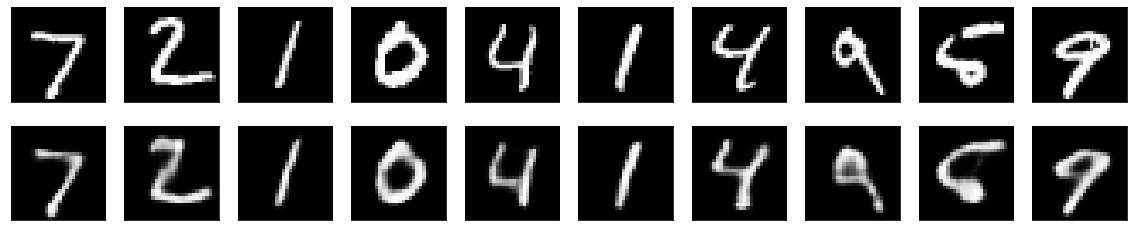

In [106]:
encoded_imgs = conv_encoder.predict(x_test_conv)
decoded_imgs = conv_autoencoder.predict(x_test_conv)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


### Application to denoising

We now know how to build a convolutional autoencoder. 

We will now see how it can be used to solved denoising problem. 

We first create fake noisy data

In [107]:
# Add random noise
noise_factor = 0.5
x_train_noisy = x_train_conv + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train_conv.shape) 
x_test_noisy = x_test_conv + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test_conv.shape) 

# Value greater than 1 are set to 1 and value lower than 0 are set to zero
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Let's observe the noise we create

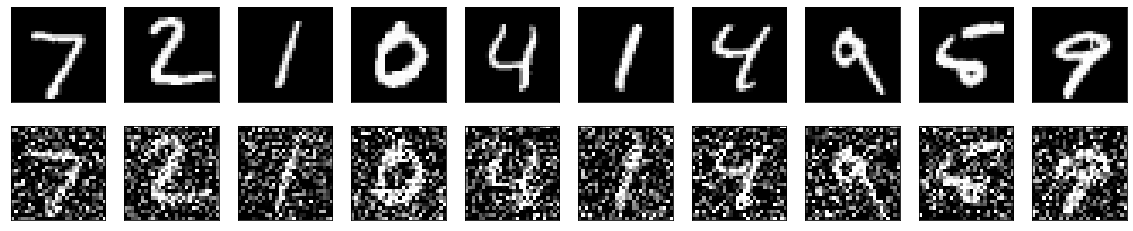

In [108]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # noisy data
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Now let's train the same convolutional model that we built above. But let train this model with noisy data as an input and the original data as the output.

In [110]:
conv_encoder = km.Sequential(name="ConvEncoderModel")
conv_encoder.add(kl.Conv2D(16, (3,3) , activation='relu', input_shape=(28,28,1) , padding='same' ))
conv_encoder.add(kl.MaxPooling2D((2, 2), padding='same'))
conv_encoder.add(kl.Conv2D(8, (3, 3), activation='relu', padding='same'))
conv_encoder.add(kl.MaxPooling2D((2, 2), padding='same'))
conv_encoder.add(kl.Conv2D(8, (3, 3), activation='relu', padding='same'))
conv_encoder.add(kl. MaxPooling2D((2, 2), padding='same'))

conv_decoder = km.Sequential(name="ConvDecoderModel")
conv_decoder.add(kl.Conv2D(8, (3, 3), activation='relu', input_shape = conv_encoder.get_output_shape_at(-1)[-3:], padding='same'))
conv_decoder.add(kl.UpSampling2D((2, 2)))
conv_decoder.add(kl.Conv2D(8, (3, 3), activation='relu', padding='same'))
conv_decoder.add(kl.UpSampling2D((2, 2)))
conv_decoder.add(kl.Conv2D(16, (3, 3), activation='relu'))
conv_decoder.add(kl.UpSampling2D((2, 2)))
conv_decoder.add(kl.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

conv_autoencoder = km.Sequential(name="ConvAutoencoderModel")
conv_autoencoder.add(conv_encoder)
conv_autoencoder.add(conv_decoder)

conv_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
conv_autoencoder.fit(x_train_noisy, x_train_conv, epochs=10, batch_size=256, validation_data=(x_test_noisy, x_test_conv))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 45us/sample - loss: 0.3033 - val_loss: 0.2025
Epoch 2/10
60000/60000 [==============================] - 2s 39us/sample - loss: 0.1895 - val_loss: 0.1786
Epoch 3/10
60000/60000 [==============================] - 2s 39us/sample - loss: 0.1742 - val_loss: 0.1677
Epoch 4/10
60000/60000 [==============================] - 2s 39us/sample - loss: 0.1653 - val_loss: 0.1602
Epoch 5/10
60000/60000 [==============================] - 2s 38us/sample - loss: 0.1590 - val_loss: 0.1549
Epoch 6/10
60000/60000 [==============================] - 2s 39us/sample - loss: 0.1545 - val_loss: 0.1512
Epoch 7/10
60000/60000 [==============================] - 2s 39us/sample - loss: 0.1513 - val_loss: 0.1486
Epoch 8/10
60000/60000 [==============================] - 2s 39us/sample - loss: 0.1488 - val_loss: 0.1461
Epoch 9/10
60000/60000 [==============================] - 2s 39us/sample - loss: 0.1467 - val_

Now, we pass the noisy test data into the trained autoencorder in order to denoise this data.

In [111]:
x_test_denoised = conv_autoencoder.predict(x_test_noisy)

Here are the results of the denoised data

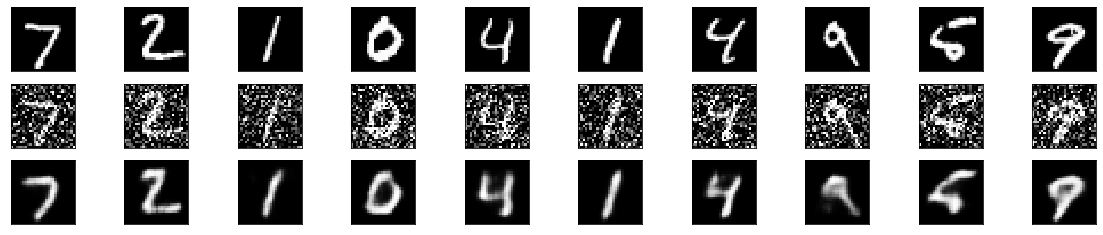

In [112]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # noisy data
    ax = plt.subplot(3, n, i + n+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # denoised data
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(x_test_denoised[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**Exercise** : Play with different architecture to decrease loss function

In [117]:
conv_encoder = km.Sequential(name="ConvEncoderModel")
conv_encoder.add(kl.Conv2D(16, (3,3), input_shape=(28,28,1) , padding='same'))
conv_encoder.add(kl.LeakyReLU(1/55))
conv_encoder.add(kl.MaxPooling2D((2, 2), padding='same'))
conv_encoder.add(kl.Conv2D(8, (3, 3), padding='same'))
conv_encoder.add(kl.LeakyReLU(1/55))
conv_encoder.add(kl.MaxPooling2D((2, 2), padding='same'))
conv_encoder.add(kl.Conv2D(8, (3, 3), padding='same'))
conv_encoder.add(kl.LeakyReLU(1/55))
conv_encoder.add(kl. MaxPooling2D((2, 2), padding='same'))

conv_decoder = km.Sequential(name="ConvDecoderModel")
conv_decoder.add(kl.Conv2D(8, (3, 3), input_shape = conv_encoder.get_output_shape_at(-1)[-3:], padding='same'))
conv_encoder.add(kl.LeakyReLU(1/55))
conv_decoder.add(kl.UpSampling2D((2, 2)))
conv_decoder.add(kl.Conv2D(8, (3, 3), padding='same'))
conv_encoder.add(kl.LeakyReLU(1/55))
conv_decoder.add(kl.UpSampling2D((2, 2)))
conv_decoder.add(kl.Conv2D(16, (3, 3)))
conv_encoder.add(kl.LeakyReLU(1/55))
conv_decoder.add(kl.UpSampling2D((2, 2)))
conv_decoder.add(kl.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

conv_autoencoder = km.Sequential(name="ConvAutoencoderModel")
conv_autoencoder.add(conv_encoder)
conv_autoencoder.add(conv_decoder)

conv_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
conv_autoencoder.fit(x_train_noisy, x_train_conv, epochs=30, batch_size=128, validation_data=(x_test_noisy, x_test_conv))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 5s 77us/sample - loss: 0.2460 - val_loss: 0.1954
Epoch 2/30
60000/60000 [==============================] - 4s 68us/sample - loss: 0.1869 - val_loss: 0.1764
Epoch 3/30
60000/60000 [==============================] - 4s 69us/sample - loss: 0.1744 - val_loss: 0.1698
Epoch 4/30
60000/60000 [==============================] - 4s 71us/sample - loss: 0.1688 - val_loss: 0.1639
Epoch 5/30
60000/60000 [==============================] - 4s 69us/sample - loss: 0.1637 - val_loss: 0.1600
Epoch 6/30
60000/60000 [==============================] - 4s 70us/sample - loss: 0.1598 - val_loss: 0.1562
Epoch 7/30
60000/60000 [==============================] - 4s 69us/sample - loss: 0.1565 - val_loss: 0.1535
Epoch 8/30
60000/60000 [==============================] - 4s 70us/sample - loss: 0.1542 - val_loss: 0.1516
Epoch 9/30
60000/60000 [==============================] - 4s 69us/sample - loss: 0.1526 - val_